In [1]:
from fastai.vision.all import *
import timm
from timm.models.layers import create_attn, get_attn
import pdb

In [2]:
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

# Building Unet on top of Timm and Fast.ai  
- Understanding Unet 
    - Notes from Unet paper
- Build an encoder model using Timm
- Build a Decoder using Fastai Conv Blocks & Timm attention layers.
- Train it using Fastai
- Areas to explore

![Unet](imgs/Unet.png)

## Unet paper notes
- Contracting path that captures context & symmetric path enabling precise localisation.
- Built on top of FCN.
    - Contracting Layers + More layers replaced by pooling layers with UpSampling operations.
- Importan contribution of Unet paper is use of a Decoder with a large number of feature channels, which results in decode being simmilar to the contracting (Encoder) path.
- No Fully connected layers.
- More data augmentation since little data is available for medical imaging.

## Train FastAI Unet model

### Building data pipeline

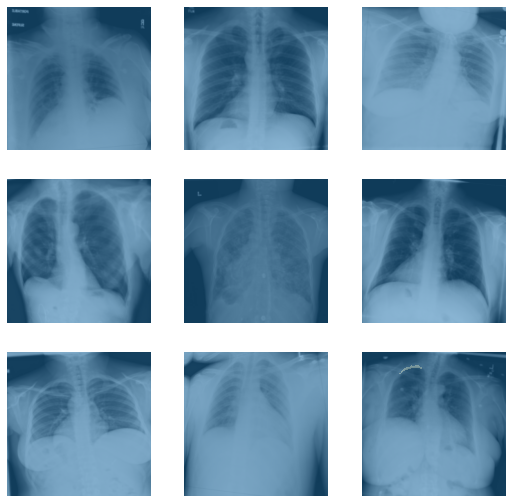

In [3]:
data_path = Path('data/')
size=224
bs=64
def get_data(size,tfms=None,bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),*aug_transforms()]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','mask'))
    return db.dataloaders(source=data_path/'train'/'images',bs=bs)

dls = get_data(size=224,bs=64)
dls.show_batch(max_n=9)

### Train Unet

In [7]:
dls = get_data(size=224,bs=64)
learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.020034,0.015531,0.771321,00:57


epoch,train_loss,valid_loss,dice,time
0,0.014187,0.012072,0.771306,00:49
1,0.012123,0.012335,0.786515,00:49
2,0.010647,0.009985,0.800342,00:50
3,0.009116,0.008770,0.803184,00:49
4,0.008220,0.008482,0.804653,00:51


## Building an Encoder using Timm

In [4]:
class Encoder(Module):
    def __init__(self, model_name='resnext50_32x4d'):
        self.encoder = timm.create_model(model_name, features_only=True, pretrained=True)
        
    def forward(self, x):
        return self.encoder(x)

In [5]:
timm_models = timm.list_models(pretrained=True)

In [6]:
timm_models[:4]

['adv_inception_v3', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224']

In [7]:
timm_models.index('resnetrs50')

222

In [8]:
dummy_batch = torch.rand((2,3,224,224))
enc = Encoder('resnetrs50')

In [9]:
for o in enc(dummy_batch):
    print(o.shape)

torch.Size([2, 64, 112, 112])
torch.Size([2, 256, 56, 56])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1024, 14, 14])
torch.Size([2, 2048, 7, 7])


## UnetBlock

In [5]:
from timm.models.layers import create_attn, get_attn

In [4]:
ConvLayer(3,64)

ConvLayer(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [5]:
noop??

Signature: noop(x=None, *args, **kwargs)
Source:   
def noop (x=None, *args, **kwargs):
    "Do nothing"
    return x
File:      /opt/conda/lib/python3.8/site-packages/fastai/imports.py
Type:      function


In [6]:
class UnetBlock(Module):
    def __init__(self,in_channels,chanels,out_channels,attn=None):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        self.attn_layer = attn(out_channels) if attn else noop
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attn_layer(x)
        return x

Some of the available timm attention models 
- se
- ese
- eca
- ceca
- cbam
- lcbam

## Using Hyper Columns

In [7]:
def calc_hyperfeats(d1,d2,d3,d4,d5):
    hyperfeats = torch.cat((
                         d1,
                         F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                         F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                         F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                         F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False)), 1)
    return hyperfeats

## Connecting Encoder and Decoder

In [7]:
class UnetDecoder(Module):
    def __init__(self, fs=32, expansion=4,n_out=1, hypercol=False,attn=None):
        center_ch = 512*expansion
        decoder5_ch = center_ch + (256*expansion)
        channels = 512
        self.hypercol = hypercol
        self.center = nn.Sequential(ConvLayer(center_ch,center_ch),ConvLayer(center_ch,center_ch//2))
        self.decoder5 = UnetBlock(decoder5_ch,channels,fs,attn) 
        self.decoder4 = UnetBlock(256*expansion+fs,256,fs,attn) 
        self.decoder3 = UnetBlock(128*expansion+fs,128,fs,attn)
        self.decoder2 = UnetBlock(64*expansion+fs,64,fs,attn)
        self.decoder1 = UnetBlock(fs,fs,fs,attn)
        if hypercol:
            self.logit = nn.Sequential(ConvLayer(fs*5,fs*2),ConvLayer(fs*2,fs),nn.Conv2d(fs,n_out,kernel_size=1))
        else:
            self.logit = nn.Sequential(ConvLayer(fs,fs//2),ConvLayer(fs//2,fs//2),nn.Conv2d(fs//2,n_out,kernel_size=1))
        
    def forward(self, feats):
        e1,e2,e3,e4,e5 = feats #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)
        return self.logit(calc_hyperfeats(d1,d2,d3,d4,d5)) if self.hypercol else self.logit(d1)
    
        
class Unet(Module):
    def __init__(self, fs=32, expansion=4, model_name='resnext50_32x4d',n_out=1,hypercol=False,attn=None):
        self.encoder = Encoder(model_name)
        self.decoder = UnetDecoder(fs=fs, expansion=expansion,n_out=n_out,hypercol=hypercol,attn=attn)
        
    def forward(self, x):
        feats = self.encoder(x) #'64 256 512 1024 2048'
        out = self.decoder(feats)
        return out

## Custom splitter to apply Discriminative learning

In [ ]:
def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

## Training our Unet

### Simple Unet 
- Model resnet34
- IMG_SZ 224
- BS 64
- HyperColumns False
- Attention False

In [16]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34'),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.325711,0.234399,0.003778,00:50


epoch,train_loss,valid_loss,dice,time
0,0.169179,0.145323,0.770384,00:48
1,0.087763,0.065209,0.774570,00:50
2,0.045642,0.035491,0.781888,00:49
3,0.030682,0.027117,0.779799,00:47
4,0.026821,0.025806,0.782120,00:49


### Unet + Attention
- Model resnet34
- IMG_SZ 224
- BS 64
- HyperColumns False
- Attention True

In [19]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.293342,0.172339,0.690021,00:48


epoch,train_loss,valid_loss,dice,time
0,0.110899,0.086654,0.771321,00:50
1,0.046046,0.030664,0.773490,00:51
2,0.024547,0.019345,0.784098,00:50
3,0.017683,0.015264,0.786959,00:49
4,0.016226,0.014700,0.784825,00:48


### Unet + Attention + resnetrs50
- Model resnetrs50
- IMG_SZ 224
- BS 64
- HyperColumns False
- Attention True

In [19]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.374307,0.222531,0.012138,01:24


epoch,train_loss,valid_loss,dice,time
0,0.152511,0.119040,0.737422,01:25
1,0.058157,0.039352,0.783053,01:25
2,0.027107,0.021684,0.744351,01:25
3,0.018543,0.016395,0.791781,01:26
4,0.016321,0.015701,0.793343,01:26


### Unet + Attention + resnetrs50 + hypercolums
- Model resnetrs50
- IMG_SZ 224
- BS 64
- HyperColumns True
- Attention True

In [22]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.226750,0.096161,0.771852,01:44


epoch,train_loss,valid_loss,dice,time
0,0.063837,0.044332,0.770265,01:42
1,0.025336,0.016859,0.788926,01:42
2,0.015546,0.012553,0.790448,01:42
3,0.012503,0.011050,0.800482,01:42
4,0.011248,0.010762,0.793894,01:42


### Unet + Attention + resnetrs50 + hypercolums - Training just the encoder
- Model resnetrs50
- IMG_SZ 224
- BS 64
- HyperColumns True
- Attention True

In [23]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)

In [24]:
learn.freeze()

In [25]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.162613,0.045737,0.773041,01:37
1,0.024213,0.012817,0.760953,01:37
2,0.012630,0.010332,0.787673,01:37
3,0.010760,0.009211,0.797630,01:37
4,0.009325,0.008583,0.788808,01:37
5,0.008449,0.008430,0.805786,01:38
6,0.008168,0.008057,0.813894,01:37
7,0.007434,0.008201,0.812261,01:38
8,0.006879,0.008152,0.814704,01:37
9,0.006821,0.008141,0.815504,01:37


In [13]:
dls = get_data(size=512,bs=16)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.freeze()
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.015837,0.012402,0.773469,06:35
1,0.010243,0.008686,0.783408,06:23
2,0.009620,0.008977,0.817096,06:23
3,0.008460,0.007308,0.812334,06:22
4,0.008393,0.007156,0.772636,06:22
5,0.008045,0.007175,0.782227,06:23
6,0.007417,0.006747,0.816297,06:22
7,0.006087,0.006827,0.827817,06:23
8,0.005753,0.006776,0.806532,06:22
9,0.005687,0.006760,0.819094,06:23


In [8]:
dls = get_data(size=768,bs=8)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.freeze()
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.011484,0.010527,0.765555,15:54
1,0.011612,0.008659,0.765769,15:29
2,0.009950,0.008329,0.722114,15:29
3,0.008039,0.007804,0.810732,15:28
4,0.007389,0.007525,0.827005,15:29
5,0.006827,0.006713,0.802818,15:28
6,0.006330,0.006421,0.794071,15:29
7,0.006542,0.006562,0.820730,15:29
8,0.005410,0.006354,0.809176,15:29
9,0.005773,0.006430,0.821051,15:28


## Areas to explore
- Try different architecture like efficientnet
- Use output channels in Unet block similar to the paper